<a href="https://colab.research.google.com/github/briansrebrenik/Final_Project/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.applications.densenet import DenseNet121
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_score
from sklearn.preprocessing import MultiLabelBinarizer
%matplotlib inline

In [0]:
!mkdir -p ~/.kaggle
!cp /content/drive/My\ Drive/Colab\ Notebooks/x_ray/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download nih-chest-xrays/data -f images_002.zip -p /content --unzip
!kaggle datasets download nih-chest-xrays/data -f images_003.zip -p /content --unzip
!kaggle datasets download nih-chest-xrays/data -f images_004.zip -p /content --unzip
!kaggle datasets download nih-chest-xrays/data -f images_005.zip -p /content --unzip
!kaggle datasets download nih-chest-xrays/data -f images_006.zip -p /content --unzip
!kaggle datasets download nih-chest-xrays/data -f images_007.zip -p /content --unzip

100% 3.67G/3.68G [01:52<00:00, 25.8MB/s]
100% 3.68G/3.68G [01:52<00:00, 35.1MB/s]
100% 3.65G/3.66G [01:08<00:00, 55.3MB/s]
100% 3.66G/3.66G [01:08<00:00, 57.1MB/s]
100% 3.56G/3.57G [01:03<00:00, 51.7MB/s]
100% 3.57G/3.57G [01:03<00:00, 60.5MB/s]
100% 3.66G/3.66G [01:30<00:00, 42.0MB/s]
100% 3.66G/3.66G [01:30<00:00, 43.6MB/s]
100% 3.71G/3.71G [01:10<00:00, 57.7MB/s]
100% 3.71G/3.71G [01:10<00:00, 56.7MB/s]
100% 3.74G/3.74G [01:02<00:00, 55.4MB/s]
100% 3.74G/3.74G [01:02<00:00, 64.5MB/s]


In [0]:
!unzip /content/images_002.zip && rm /content/images_002.zip
!unzip /content/images_003.zip && rm /content/images_003.zip
!unzip /content/images_004.zip && rm /content/images_004.zip
!unzip /content/images_005.zip && rm /content/images_005.zip
!unzip /content/images_006.zip && rm /content/images_006.zip
!unzip /content/images_007.zip && rm /content/images_007.zip


Archive:  /content/images_002.zip
  inflating: images/00001336_000.png  
  inflating: images/00001337_000.png  
  inflating: images/00001338_000.png  
  inflating: images/00001338_001.png  
  inflating: images/00001338_002.png  
  inflating: images/00001338_003.png  
  inflating: images/00001339_000.png  
  inflating: images/00001340_000.png  
  inflating: images/00001341_000.png  
  inflating: images/00001342_000.png  
  inflating: images/00001342_001.png  
  inflating: images/00001343_000.png  
  inflating: images/00001344_000.png  
  inflating: images/00001345_000.png  
  inflating: images/00001346_000.png  
  inflating: images/00001347_000.png  
  inflating: images/00001347_001.png  
  inflating: images/00001347_002.png  
  inflating: images/00001348_000.png  
  inflating: images/00001349_000.png  
  inflating: images/00001350_000.png  
  inflating: images/00001351_000.png  
  inflating: images/00001352_000.png  
  inflating: images/00001353_000.png  
  inflating: images/00001354_0

In [0]:
image_names = [x[2] for x in os.walk('/content/images')]

In [0]:
image_names = image_names[0]
len(image_names)

60000

In [0]:
!kaggle datasets download nih-chest-xrays/data -f Data_Entry_2017.csv -p /content --unzip

  0% 0.00/924k [00:00<?, ?B/s]
100% 924k/924k [00:00<00:00, 59.0MB/s]


(1, 150, 150, 3)


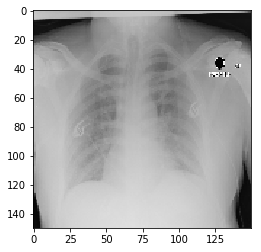

In [0]:
sample_image = image_names[0]
img = image.load_img(f'/content/images/{sample_image}', target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

#Follow the Original Model Preprocessing
img_tensor /= 255.

#Check tensor shape
print(img_tensor.shape)

#Preview an image
plt.imshow(img_tensor[0])
plt.show()

In [0]:
labels = pd.read_csv('/content/Data_Entry_2017.csv.zip')


In [0]:
labels.rename(columns={'Image Index': 'image_index', 'Finding Labels': 'target'}, inplace=True)
labels.head()

,image_index,target,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [0]:
labels.target = labels.target.apply(lambda x: tuple(x.split('|')))

In [0]:
# labels.target = labels.target.map(lambda z: [x for x in z if x != 'No Finding'])
# print(len(labels))
# labels.head()

40000


,image_index,target,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00010080_002.png,[Atelectasis],2,10080,34,M,AP,2500,2048,0.168,0.168
1,00004063_000.png,"[Cardiomegaly, Effusion]",0,4063,37,F,PA,2048,2500,0.171,0.171
2,00010469_002.png,[Effusion],2,10469,36,M,PA,2992,2991,0.143,0.143
3,00009984_000.png,"[Fibrosis, Mass]",0,9984,52,F,PA,2048,2500,0.168,0.168
4,00001373_017.png,[Infiltration],17,1373,59,M,AP,3056,2544,0.139,0.139


In [0]:
mlb = MultiLabelBinarizer()
target = mlb.fit_transform(labels.target)


In [0]:
for i in range(len(mlb.classes_)):
  labels[mlb.classes_[i]] = [x[i] for x in target]

In [0]:
labels.drop(columns=['target'], inplace=True)
labels.head()

,image_index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00013600_000.png,0,13600,45,M,AP,2500,2048,0.168,0.168,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,00010080_002.png,2,10080,34,M,AP,2500,2048,0.168,0.168,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00004063_000.png,0,4063,37,F,PA,2048,2500,0.171,0.171,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00014251_016.png,16,14251,70,M,AP,2500,2048,0.168,0.168,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00013279_000.png,0,13279,45,M,PA,2500,2048,0.168,0.168,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [0]:
totals = {}
for x in labels.columns[-15:]:
  totals[x] = sum(labels.loc[:, x])

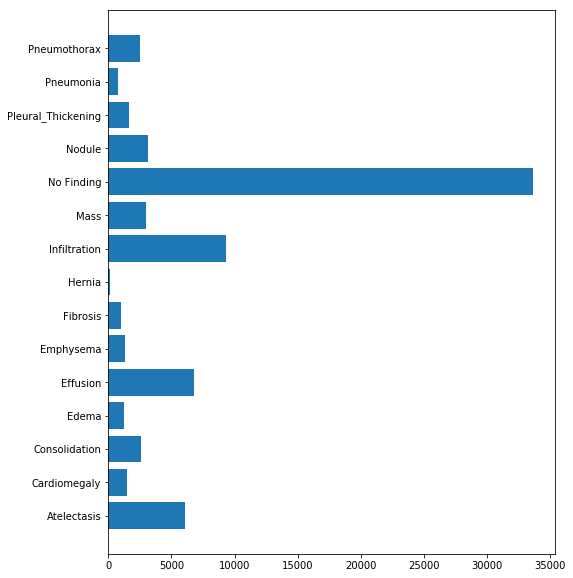

In [0]:
plt.figure(figsize=(8,10))
plt.barh([x[0] for x in totals.items()], [x[1] for x in totals.items()])
plt.show()

In [0]:
labels['No Finding'].value_counts()

1    33670
0    26330
Name: No Finding, dtype: int64

In [0]:
labels['No Finding'] = labels['No Finding'].astype(str)

In [0]:
#splitting to train/validation
train = labels.sample(frac=.75, random_state=1)
validation = labels.drop(train.index)


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [0]:
tdg = train_datagen.flow_from_dataframe(dataframe=train, 
                                                       directory='/content/images', 
                                                       x_col='image_index',
                                                       y_col='No Finding', target_size = (224,224),
                                                       class_mode='binary',
                                                       batch_size=32, color_mode = 'rgb')


Found 45000 images belonging to 2 classes.


In [0]:
vdg = val_datagen.flow_from_dataframe(dataframe=validation, 
                                                       directory='/content/images', 
                                                       x_col='image_index',
                                                       y_col='No Finding', target_size = (224,224),
                                                       class_mode='binary',
                                                       batch_size=250, color_mode = 'rgb')


Found 15000 images belonging to 2 classes.


In [0]:
base_model = DenseNet121(input_shape=(224, 224, 3), weights= 'imagenet', 
                        include_top=False, pooling='avg')

29089792/29084464 [==============================] - 10s 0us/step


In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [0]:
model = Sequential()
model.add(base_model)
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=adam(lr=.001),
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 1664)              12642880  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               852480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 13,561,153
Trainable params: 918,273
Non-trainable params: 12,642,880
_________________________________________________________________


In [0]:
# checkpoint = ModelCheckpoint(monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = True, )

learning = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                             patience=1, verbose=1, 
                             mode="min", min_lr=1e-8)

early = EarlyStopping(monitor="val_acc", patience=10, mode='min',
                      restore_best_weights=True)
callbacks_list = [early]



In [0]:
history = model.fit_generator(tdg, steps_per_epoch= 140, epochs=100, 
                              validation_data=vdg, callbacks = callbacks_list, 
                              validation_steps=12, workers=2, 
                              use_multiprocessing=True)


Instructions for updating:
Use tf.cast instead.
Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


140/140 [==============================] - 168s 1s/step - loss: 0.6859 - acc: 0.5893 - val_loss: 0.6700 - val_acc: 0.5693
Epoch 2/100
140/140 [==============================] - 122s 869ms/step - loss: 0.6375 - acc: 0.6413 - val_loss: 0.7751 - val_acc: 0.5780
Epoch 3/100
140/140 [==============================] - 124s 886ms/step - loss: 0.6401 - acc: 0.6391 - val_loss: 0.6540 - val_acc: 0.5927
Epoch 4/100
140/140 [==============================] - 124s 884ms/step - loss: 0.6408 - acc: 0.6471 - val_loss: 0.7464 - val_acc: 0.5787
Epoch 5/100
 34/140 [======>.......................] - ETA: 1:13 - loss: 0.6328 - acc: 0.6535

Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 100, in __next__
    return self.next(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 112, in next
    return self._get_batches_of_transformed_samples(index_ar

KeyboardInterrupt: ignored

In [0]:
preds = model.predict_generator(vdg, steps=32, workers=2,
                               use_multiprocessing=True)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:398: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


In [0]:
y = np.array(validation['No Finding'].astype(int))

In [0]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      7786
           1       0.00      0.00      0.00       214

    accuracy                           0.97      8000
   macro avg       0.49      0.50      0.49      8000
weighted avg       0.95      0.97      0.96      8000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
